## Introduction Example Plots

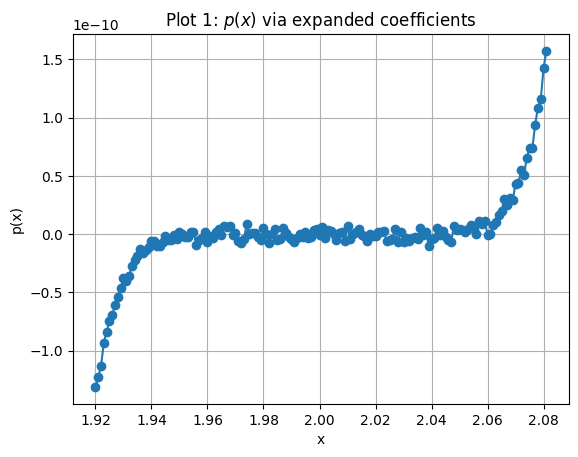

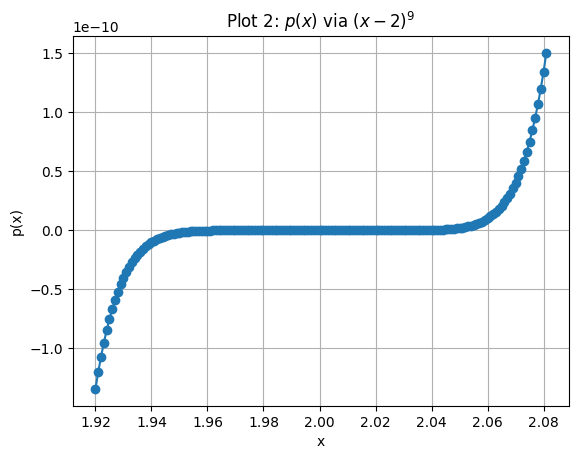

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1.920, 2.081, 0.001)
coeffs = [1, -18, 144, -672, 2016, -4032, 5376, -4608, 2304, -512]

y_coeff = np.polyval(coeffs, x)

y_factored = (x - 2.0) ** 9

plt.figure()
plt.plot(x, y_coeff, marker='o', linestyle='-')
plt.title("Plot 1: $p(x)$ via expanded coefficients")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x, y_factored, marker='o', linestyle='-')
plt.title("Plot 2: $p(x)$ via $(x-2)^9$")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()

## The Hessenberg Reduction Function (a)

In [12]:
import numpy as np
import time
from typing import List, Tuple


def build_householder_unit_vector(
        target_vector: np.ndarray
) -> np.ndarray:
    
    """
    Builds a Householder unit vector

    Args:
        1. target_vector (np.ndarray): Column vector that we want to annihilate (size ≥ 1).

    Returns:
        np.ndarray:
            The normalised Householder vector (‖v‖₂ = 1) with a real first component.

    Raises:
        1. ValueError: If 'target_vector' has zero length.
    """

    if target_vector.size == 0:
        raise ValueError("The target vector is empty; no reflector needed.")

    vector_norm: float = np.linalg.norm(target_vector)

    if vector_norm == 0.0: #nothing to annihilate – return canonical basis vector
        householder_vector: np.ndarray = np.zeros_like(target_vector)
        householder_vector[0] = 1.0
        return householder_vector

    sign_correction: float = (
        1.0 if target_vector[0].real >= 0.0 else -1.0
    )
    copy_of_target_vector: np.ndarray = target_vector.copy()
    copy_of_target_vector[0] += sign_correction * vector_norm
    householder_vector: np.ndarray = (
        copy_of_target_vector / np.linalg.norm(copy_of_target_vector)
    )
    return householder_vector


def to_hessenberg(
        original_matrix: np.ndarray,
) -> Tuple[List[np.ndarray], np.ndarray, np.ndarray]:
    
    """
    Reduce 'original_matrix' to upper Hessenberg form by Householder reflections.

    Args
        1. original_matrix (np.ndarray): Real or complex square matrix of order 'matrix_order'.

    Returns
        Tuple consisting of:

        1. householder_reflectors_list (List[np.ndarray])
        2. hessenberg_matrix (np.ndarray)
        3. accumulated_orthogonal_matrix (np.ndarray)  s.t.
          original_matrix = Q · H · Qᴴ

    Raises
        1. ValueError: If 'original_matrix' is not square.
    """

    working_matrix: np.ndarray = np.asarray(original_matrix).copy()

    if working_matrix.shape[0] != working_matrix.shape[1]:
        raise ValueError("Input matrix must be square.")

    matrix_order: int = working_matrix.shape[0]
    accumulated_orthogonal_matrix: np.ndarray = np.eye(
        matrix_order, dtype=working_matrix.dtype
    )
    householder_reflectors_list: List[np.ndarray] = []

    for column_index in range(matrix_order - 2): #extract the part of column 'column_index' that we want to zero out
        target_column_segment: np.ndarray = working_matrix[
            column_index + 1 :, column_index
        ]

        householder_vector: np.ndarray = build_householder_unit_vector(
            target_column_segment
        )  #build Householder vector for this segment
        householder_reflectors_list.append(householder_vector)

        #expand it to the full matrix dimension
        expanded_householder_vector: np.ndarray = np.zeros(
            matrix_order, dtype=working_matrix.dtype
        )
        expanded_householder_vector[column_index + 1 :] = householder_vector


        working_matrix -= 2.0 * np.outer( 
            expanded_householder_vector,
            expanded_householder_vector.conj().T @ working_matrix,
        ) #apply reflector from BOTH sides
        working_matrix -= 2.0 * np.outer(
            working_matrix @ expanded_householder_vector,
            expanded_householder_vector.conj().T,
        )

        #accumulate Q
        accumulated_orthogonal_matrix -= 2.0 * np.outer(
            accumulated_orthogonal_matrix @ expanded_householder_vector,
            expanded_householder_vector.conj().T,
        )

    hessenberg_matrix: np.ndarray = working_matrix
    return (
        householder_reflectors_list,
        hessenberg_matrix,
        accumulated_orthogonal_matrix,
    )


## Evaluating the Hessenberg Reduction Function


In [13]:
def verify_factorisation(
    matrix_size: int,
    force_symmetric: bool = False,
    random_seed: int | None = None,
) -> Tuple[float, float]:
    
    """
    Compute ‖A - QHQᴴ‖ and ‖QᴴQ - I‖ for a random matrix of size 'matrix_size'.

    Args:
        1. matrix_size (int): Desired order of the test matrix.
        2. force_symmetric (bool): If True, symmetrise the random matrix.
        3. random_seed (int | None): Seed for reproducibility.

    Returns:
        Tuple[float, float]: (residual_factorisation, residual_orthogonality)
    """
    
    random_generator = np.random.default_rng(random_seed)
    test_matrix: np.ndarray = random_generator.standard_normal(
        (matrix_size, matrix_size)
    )

    if force_symmetric:
        test_matrix = (test_matrix + test_matrix.T) / 2.0

    (
        _,
        hessenberg_matrix,
        accumulated_orthogonal_matrix,
    ) = to_hessenberg(test_matrix)

    residual_factorisation: float = np.linalg.norm(
        test_matrix
        - accumulated_orthogonal_matrix
        @ hessenberg_matrix
        @ accumulated_orthogonal_matrix.T
    )
    residual_orthogonality: float = np.linalg.norm(
        accumulated_orthogonal_matrix.T @ accumulated_orthogonal_matrix
        - np.eye(matrix_size)
    )
    return residual_factorisation, residual_orthogonality


for symmetry_flag in (False, True):
    for test_size in (5, 8, 12):
        res_fact, res_ortho = verify_factorisation(
            test_size, force_symmetric=symmetry_flag, random_seed=42
        )
        descriptor = "symmetric" if symmetry_flag else "general  "
        print(
            f"{descriptor}  size={test_size:2d} "
            f"| ‖A − QHQᵀ‖={res_fact:.1e} "
            f"| ‖QᵀQ − I‖={res_ortho:.1e}"
        )


general    size= 5 | ‖A − QHQᵀ‖=1.7e-15 | ‖QᵀQ − I‖=7.4e-16
general    size= 8 | ‖A − QHQᵀ‖=3.6e-15 | ‖QᵀQ − I‖=1.2e-15
general    size=12 | ‖A − QHQᵀ‖=9.6e-15 | ‖QᵀQ − I‖=2.0e-15
symmetric  size= 5 | ‖A − QHQᵀ‖=7.5e-16 | ‖QᵀQ − I‖=4.7e-16
symmetric  size= 8 | ‖A − QHQᵀ‖=3.5e-15 | ‖QᵀQ − I‖=1.5e-15
symmetric  size=12 | ‖A − QHQᵀ‖=1.0e-14 | ‖QᵀQ − I‖=2.9e-15
